# Install required modules for visualization

In [1]:
!pip install pandas xlrd openpyxl matplotlib hvplot plotly kaleido selenium jq wordcloud seaborn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


# Import Modules and Sankey configuration

In [2]:
import pandas as pd
import hvplot.pandas
import holoviews as hv
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import warnings
import plotly.express as px

warnings.simplefilter(action='ignore', category=UserWarning)
pd.options.mode.chained_assignment = None  # default='warn'

pd.options.plotting.backend = 'holoviews'

# function to generate sankey
def genSankey(df,cat_cols=[],value_cols='',title='Sankey Diagram'):
    # maximum of 6 value cols -> 6 colors
    colorPalette = ['#4B8BBE','#306998','#FFE873','#FFD43B','#646464']
    labelList = []
    colorNumList = []
    for catCol in cat_cols:
        labelListTemp =  list(set(df[catCol].values))
        colorNumList.append(len(labelListTemp))
        labelList = labelList + labelListTemp
        
    # remove duplicates from labelList
    labelList = list(dict.fromkeys(labelList))
    
    # define colors based on number of levels
    colorList = []
    for idx, colorNum in enumerate(colorNumList):
        colorList = colorList + [colorPalette[idx]]*colorNum
        
    # transform df into a source-target pair
    for i in range(len(cat_cols)-1):
        if i==0:
            sourceTargetDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            sourceTargetDf.columns = ['source','target','count']
        else:
            tempDf = df[[cat_cols[i],cat_cols[i+1],value_cols]]
            tempDf.columns = ['source','target','count']
            sourceTargetDf = pd.concat([sourceTargetDf,tempDf])
        sourceTargetDf = sourceTargetDf.groupby(['source','target']).agg({'count':'sum'}).reset_index()
        
    # add index for source-target pair
    sourceTargetDf['sourceID'] = sourceTargetDf['source'].apply(lambda x: labelList.index(x))
    sourceTargetDf['targetID'] = sourceTargetDf['target'].apply(lambda x: labelList.index(x))
    
    # creating the sankey diagram
    data = dict(
        type='sankey',
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(
            color = "black",
            width = 0.5
          ),
          label = labelList,
          # color = colorList
        ),
        link = dict(
          source = sourceTargetDf['sourceID'],
          target = sourceTargetDf['targetID'],
          value = sourceTargetDf['count']
        )
      )
    
    layout =  dict(
        title = title,
        width = 500,
        font = dict(
          size = 10
        )
    )
       
    fig = dict(data=[data], layout=layout)
    return fig

print('Done loading library and function!')

Done loading library and function!


# Stopword configuration & wordcloud visualization

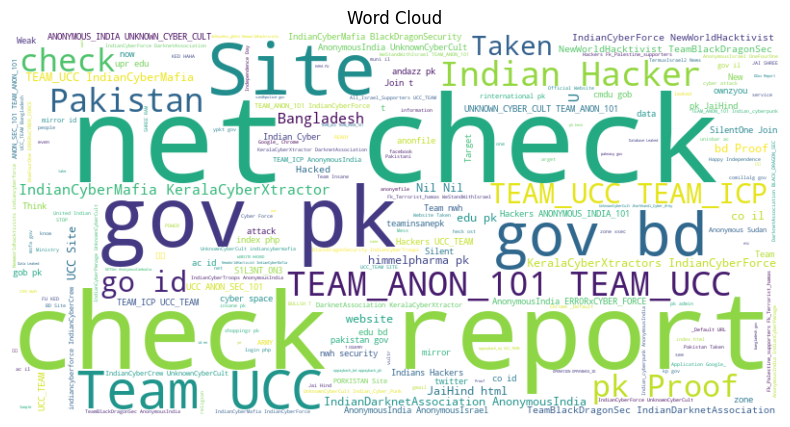

In [8]:
import pandas as pd
import re 
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Load your CSV file into a DataFrame
df = pd.read_csv('all_results.csv')

# Assuming your CSV file has a column named 'text' where the text data is stored
text_data = ' '.join(df['message'].astype(str))

# Add custom stopwords
custom_stopwords = set([
    "ada", "inikah", "sampai", "adakah", "inilah", "sana", "adakan", "itu", "sangat", "adalah",
    "itukah", "sangatlah", "adanya", "itulah", "saya", "adapun", "jadi", "se", "agak", "jangan",
    "seandainya", "agar", "janganlah", "sebab", "akan", "jika", "sebagai", "aku", "jikalau",
    "sebagaimana", "akulah", "jua", "sebanyak", "akupun", "juapun", "sebelum", "al", "juga",
    "sebelummu", "alangkah", "kalau", "sebelumnya", "allah", "kami", "sebenarnya", "amat",
    "kamikah", "secara", "antara", "kamipun", "sedang", "antaramu", "kamu", "sedangkan", "antaranya",
    "kamukah", "sedikit", "apa", "kamupun", "sedikitpun", "apa-apa", "katakan", "segala", "apabila",
    "ke", "sehingga", "apakah", "kecuali", "sejak", "apapun", "kelak", "sekalian", "atas", "kembali",
    "sekalipun", "atasmu", "kemudian", "sekarang", "atasnya", "kepada", "sekitar", "atau", "kepadaku",
    "selain", "ataukah", "kepadakulah", "selalu", "ataupun", "kepadamu", "selama", "bagaimana",
    "kepadanya", "selama-lamanya", "bagaimanakah", "kepadanyalah", "seluruh", "bagimu", "kerana",
    "seluruhnya", "baginya", "kesan", "semua", "bahawa", "ketika", "semuanya", "bahawasanya",
    "kini", "semula", "bahkan", "kita", "senantiasa", "bahwa", "ku", "sendiri", "banyak",
    "kurang", "sentiasa", "banyaknya", "lagi", "seolah", "barangsiapa", "lain", "seolah-olah",
    "bawah", "lalu", "seorangpun", "beberapa", "lamanya", "separuh", "begitu", "langsung", "sepatutnya",
    "begitupun", "lebih", "seperti", "belaka", "maha", "seraya", "belum", "mahu", "sering",
    "belumkah", "mahukah", "serta", "berada", "mahupun", "seseorang", "berapa", "maka", "sesiapa",
    "berikan", "malah", "sesuatu", "beriman", "mana", "sesudah", "berkenaan", "manakah", "sesudahnya",
    "berupa", "manapun", "sesungguhnya", "beserta", "masih", "sesungguhnyakah", "biarpun",
    "masing", "setelah", "bila", "masing-masing", "setiap", "bilakah", "melainkan", "siapa",
    "bilamana", "memang", "siapakah", "bisa", "mempunyai", "sini", "boleh", "mendapat", "situ",
    "bukan", "mendapati", "situlah", "bukankah", "mendapatkan", "suatu", "bukanlah", "mengadakan",
    "sudah", "dahulu", "mengapa", "sudahkah", "dalam", "mengapakah", "sungguh", "dalamnya",
    "mengenai", "sungguhpun", "dan", "menjadi", "supaya", "dapat", "menyebabkan", "tadinya", "dapati",
    "menyebabkannya", "tahukah", "dapatkah", "mereka", "tak", "dapatlah", "merekalah", "tanpa",
    "dari", "merekapun", "tanya", "daripada", "meskipun", "tanyakanlah", "daripadaku", "mu",
    "tapi", "daripadamu", "nescaya", "telah", "daripadanya", "niscaya", "tentang", "demi", "nya",
    "tentu", "demikian", "olah", "terdapat", "demikianlah", "oleh", "terhadap", "dengan", "orang",
    "terhadapmu", "dengannya", "pada", "termasuk", "di", "padahal", "terpaksa", "dia", "padamu",
    "tertentu", "dialah", "padanya", "tetapi", "didapat", "paling", "tiada", "didapati", "para",
    "tiadakah", "dimanakah", "pasti", "tiadalah", "engkau", "patut", "tiap", "engkaukah", "patutkah",
    "tiap-tiap", "engkaulah", "per", "tidak", "engkaupun", "pergilah", "tidakkah", "hai", "perkara",
    "tidaklah", "hampir", "perkaranya", "turut", "hampir-hampir", "perlu", "untuk", "hanya", "pernah",
    "untukmu", "hanyalah", "pertama", "wahai", "hendak", "pula", "walau", "hendaklah", "pun",
    "walaupun", "hingga", "sahaja", "ya", "ia", "saja", "yaini", "iaitu", "saling", "yaitu",
    "ialah", "pa", "nak", "sama", "yakni", "ianya", "sama-sama", "yang", "inginkah", "samakah", 
    "sambil", "yg", "itu", "ini", "tu", "ni", "abdul","abdullah","acara","ada","adalah","ahmad",
    "air","akan","akhbar","akhir","aktiviti","alam","amat","amerika","anak","anggota","antara",
    "antarabangsa","apa","apabila","april","as","asas","asean","asia","asing","atas","atau","australia",
    "awal","awam","bagaimanapun","bagi","bahagian","bahan","baharu","bahawa","baik","bandar","bank","banyak",
    "barangan","baru","baru-baru","bawah","beberapa","bekas","beliau","belum","berada","berakhir","berbanding",
    "berdasarkan","berharap","berikutan","berjaya","berjumlah","berkaitan","berkata","berkenaan","berlaku","bermula",
    "bernama","bernilai","bersama","berubah","besar","bhd","bidang","bilion","bn","boleh","bukan","bulan","bursa", 
    "cadangan","china","dagangan","dalam","dan","dana","dapat","dari","daripada","dasar","datang","datuk","demikian",
    "dengan","depan","derivatives","dewan","di","diadakan","dibuka","dicatatkan","dijangka","diniagakan","dis","disember",
    "ditutup","dolar","dr","dua","dunia","ekonomi","eksekutif","eksport","empat","enam","faedah","feb","global","hadapan",
    "hanya","harga","hari","hasil","hingga","hubungan","ia","iaitu","ialah","indeks","india","indonesia","industri","ini",
    "islam","isnin","isu","itu","jabatan","jalan","jan","jawatan","jawatankuasa","jepun","jika","jualan","juga","julai",
    "jumaat","jumlah","jun","juta","kadar","kalangan","kali","kami","kata","katanya","kaunter","kawasan","ke","keadaan",
    "kecil","kedua","kedua-dua","kedudukan","kekal","kementerian","kemudahan","kenaikan","kenyataan","kepada","kepentingan",
    "keputusan","kerajaan","kerana","kereta","kerja","kerjasama","kes","keselamatan","keseluruhan","kesihatan","ketika","ketua",
    "keuntungan","kewangan","khamis","kini","kira-kira","kita","klci","klibor","komposit","kontrak","kos","kuala","kuasa","kukuh",
    "kumpulan","lagi","lain","langkah","laporan","lebih","lepas","lima","lot","luar","lumpur","mac","mahkamah","mahu","majlis","makanan",
    "maklumat","malam","malaysia","mana","manakala","masa","masalah","masih","masing-masing","masyarakat","mata","media","mei","melalui",
    "melihat","memandangkan","memastikan","membantu","membawa","memberi","memberikan","membolehkan","membuat","mempunyai","menambah",
    "menarik","menawarkan","mencapai","mencatatkan","mendapat","mendapatkan","menerima","menerusi","mengadakan","mengambil","mengenai",
    "menggalakkan","menggunakan","mengikut","mengumumkan","mengurangkan","meningkat","meningkatkan","menjadi","menjelang","menokok",
    "menteri","menunjukkan","menurut","menyaksikan","menyediakan","mereka","merosot","merupakan","mesyuarat","minat","minggu","minyak",
    "modal","mohd","mudah","mungkin","naik","najib","nasional","negara","negara-negara","negeri","niaga","nilai","nov","ogos","okt","oleh",
    "operasi","orang","pada","pagi","paling","pameran","papan","para","paras","parlimen","parti","pasaran","pasukan","pegawai","pejabat",
    "pekerja","pelabur","pelaburan","pelancongan","pelanggan","pelbagai","peluang","pembangunan","pemberita","pembinaan","pemimpin",
    "pendapatan","pendidikan","penduduk","penerbangan","pengarah","pengeluaran","pengerusi","pengguna","pengurusan","peniaga","peningkatan",
    "penting","peratus","perdagangan","perdana","peringkat","perjanjian","perkara","perkhidmatan","perladangan","perlu","permintaan","perniagaan",
    "persekutuan","persidangan","pertama","pertubuhan","pertumbuhan","perusahaan","peserta","petang","pihak","pilihan","pinjaman","polis","politik",
    "presiden","prestasi","produk","program","projek","proses","proton","pukul","pula","pusat","rabu","rakan","rakyat","ramai","rantau","raya","rendah","ringgit","rumah","sabah","sahaja","saham","sama","sarawak","satu","sawit","saya","sdn","sebagai","sebahagian","sebanyak","sebarang","sebelum","sebelumnya","sebuah","secara","sedang","segi","sehingga","sejak","sekarang","sektor","sekuriti","selain","selama","selasa","selatan","selepas","seluruh","semakin","semalam","semasa","sementara","semua","semula","sen","sendiri","seorang","sepanjang","seperti","sept","september","serantau","seri","serta","sesi","setiap","setiausaha","sidang","singapura","sini","sistem","sokongan","sri","sudah","sukan","suku","sumber","supaya","susut","syarikat","syed","tahap","tahun","tan","tanah","tanpa","tawaran","teknologi","telah","tempat","tempatan","tempoh","tenaga","tengah","tentang","terbaik","terbang","terbesar","terbuka","terdapat","terhadap","termasuk","tersebut","terus","tetapi","thailand","tiada","tidak","tiga","timbalan","timur","tindakan","tinggi","tun","tunai","turun","turut","unit","untuk","untung","urus","usaha","utama","walaupun","wang","wanita","wilayah","yang"
    ,"rm", "a", "5", "in", "of", "4","2018","and", "foto", "la", "dah", "nk", "kena", "ini.", "2", "3", "2021", "to", "1", "muhammad", "buat", "the", "off", "je", "org", "lah", "x", "mcm", "dgn", "kau", "utk", "kat", "dlm", "dh", "ko", "kan", "dulu", "lg", "pulak", "wa", "mmg", "jgn",
    "n", "sbb", "ckp", "punya", "tp", "cakap", "sgt", "dpt", "jd", "tahu", "how", "got", "if", "many", "had", "have", "not", "sir", "Sir",
    "live", "done", "k", "kt", "vc", "follow", "is", "that", "are", "for", "they", "be", "it", "he", "has", "was", "will", "with", "on",
    "from", "who", "or", "this", "about", "you", "by", "i", "his", "said", "all", "do", "just", "Mr", "s", "am", "job", "youre", "https", "host"])
stopwords = set(STOPWORDS)
stopwords.update(custom_stopwords)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text_data)

# Plot the WordCloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

In [10]:
df = pd.read_csv('all_results.csv')
df.head()

time  \
0  2023-09-25 20:31:26+00:00   
1  2023-07-18 15:36:50+00:00   
2  2023-07-12 18:25:51+00:00   
3  2023-10-29 15:53:19+00:00   
4  2023-10-28 19:51:17+00:00   

                                             message  message_id  channel_id  \
0  בגדול ברוסיה/אוקראינה זה לחורף כי רוב הזמן\nCh...       94361  1351412444   
1  ההאקר שפרץ ל-Uber ול-Rockstar Games התברר כאוט...       84744  1351412444   
2  לטובת מי שאיכשהו פספס: \n\nהותר לפרסום שמו של ...       84031  1351412444   
3        דרך אגב הוא עובד עם חסימות לפי id? ידוע לך?      107796  1351412444   
4  Report racist  put in blacklist 🇮🇱🐀 bastards r...      107632  1351412444   

  search_term                              link  
0         .af   https://t.me/c/1351412444/94361  
1         .bt   https://t.me/c/1351412444/84744  
2         .bt   https://t.me/c/1351412444/84031  
3         .id  https://t.me/c/1351412444/107796  
4         .id  https://t.me/c/1351412444/107632

In [11]:
kw_df = pd.read_csv('keywords.csv')
kw_df.head()

keyword      country
0  Afghanistan  Afghanistan
1          .af  Afghanistan
2      .gov.af  Afghanistan
3      Algeria      Algeria
4          .dz      Algeria

In [12]:
ch_df= pd.read_csv('Channel_id.csv')
ch_df.head()

id_channel                   group_name
0  1601423054           IT ARMY of Ukraine
1  1351412444         Cyber Club (Support)
2  1542954397             Termux Israel 🇮🇱
3  1630738080           𝐈𝐍𝐃𝐈𝐀𝐍 𝐂𝐘𝐁𝐄𝐑 𝐅𝐎𝐑𝐂𝐄
4  1920809906  Sιʅҽɳƚ Oɳҽ (कट्टर हिन्दू 🚩)

# Data Organization

## Combine "all_results.csv" & "keywords.csv" Dataset

In [13]:
df['country'] = [kw_df[kw_df['keyword']==search_term]['country'].values[0] for search_term in df['search_term']]
df.datetime = pd.to_datetime(df.time)
df['date'] = df.datetime.dt.date
df['month'] = df.datetime.dt.month
df = df[['time', 'month', 'date', 'country',  'search_term', 'message_id', 'channel_id', 'message', 'link']]
df.head()

time  month        date      country search_term  \
0  2023-09-25 20:31:26+00:00      9  2023-09-25  Afghanistan         .af   
1  2023-07-18 15:36:50+00:00      7  2023-07-18       Bhutan         .bt   
2  2023-07-12 18:25:51+00:00      7  2023-07-12       Bhutan         .bt   
3  2023-10-29 15:53:19+00:00     10  2023-10-29    Indonesia         .id   
4  2023-10-28 19:51:17+00:00     10  2023-10-28    Indonesia         .id   

   message_id  channel_id                                            message  \
0       94361  1351412444  בגדול ברוסיה/אוקראינה זה לחורף כי רוב הזמן\nCh...   
1       84744  1351412444  ההאקר שפרץ ל-Uber ול-Rockstar Games התברר כאוט...   
2       84031  1351412444  לטובת מי שאיכשהו פספס: \n\nהותר לפרסום שמו של ...   
3      107796  1351412444        דרך אגב הוא עובד עם חסימות לפי id? ידוע לך?   
4      107632  1351412444  Report racist  put in blacklist 🇮🇱🐀 bastards r...   

                               link  
0   https://t.me/c/1351412444/94361  
1   https://t.me/c/1351412444/84744  
2   https://t.me/c/1351412444/84031  
3  https://t.me/c/1351412444/107796  
4  https://t.me/c/1351412444/107632

## Combine new DF with "Channel_id.csv" Dataset

In [14]:
df['group_name'] = [ch_df[ch_df['id_channel'] == search_term]['group_name'].values[0] if not ch_df[ch_df['id_channel'] == search_term].empty else None for search_term in df['channel_id']]
df['datetime'] = pd.to_datetime(df['time'])
df['date'] = df['datetime'].dt.date
df['month'] = df['datetime'].dt.month
df = df[['time', 'month', 'date', 'country', 'search_term', 'message_id', 'channel_id', 'message', 'link', 'group_name']]
df.head()

time  month        date      country search_term  \
0  2023-09-25 20:31:26+00:00      9  2023-09-25  Afghanistan         .af   
1  2023-07-18 15:36:50+00:00      7  2023-07-18       Bhutan         .bt   
2  2023-07-12 18:25:51+00:00      7  2023-07-12       Bhutan         .bt   
3  2023-10-29 15:53:19+00:00     10  2023-10-29    Indonesia         .id   
4  2023-10-28 19:51:17+00:00     10  2023-10-28    Indonesia         .id   

   message_id  channel_id                                            message  \
0       94361  1351412444  בגדול ברוסיה/אוקראינה זה לחורף כי רוב הזמן\nCh...   
1       84744  1351412444  ההאקר שפרץ ל-Uber ול-Rockstar Games התברר כאוט...   
2       84031  1351412444  לטובת מי שאיכשהו פספס: \n\nהותר לפרסום שמו של ...   
3      107796  1351412444        דרך אגב הוא עובד עם חסימות לפי id? ידוע לך?   
4      107632  1351412444  Report racist  put in blacklist 🇮🇱🐀 bastards r...   

                               link            group_name  
0   https://t.me/c/1351412444/94361  Cyber Club (Support)  
1   https://t.me/c/1351412444/84744  Cyber Club (Support)  
2   https://t.me/c/1351412444/84031  Cyber Club (Support)  
3  https://t.me/c/1351412444/107796  Cyber Club (Support)  
4  https://t.me/c/1351412444/107632  Cyber Club (Support)

# Pie Chart Visualization

## Hashtag Extraction

In [15]:
import re

def extract_hashtags(text):
    if isinstance(text, str):  # Check if the value is a string
        hashtags = re.findall(r'#\w+', text)
        return ' '.join(hashtags)  # Convert list to a space-separated string
    else:
        return ''

# Apply function to create a new column with extracted hashtags
df['hashtags'] = df['message'].apply(extract_hashtags)

# Filter rows based on a specific hashtag
python_related_rows = df[df['hashtags'].str.contains('#python')]

# Save the final result to a new CSV file
#f.to_csv('result_with_hashtags.csv', index=False)

# Show the final result
df.head()

time  month        date      country search_term  \
0  2023-09-25 20:31:26+00:00      9  2023-09-25  Afghanistan         .af   
1  2023-07-18 15:36:50+00:00      7  2023-07-18       Bhutan         .bt   
2  2023-07-12 18:25:51+00:00      7  2023-07-12       Bhutan         .bt   
3  2023-10-29 15:53:19+00:00     10  2023-10-29    Indonesia         .id   
4  2023-10-28 19:51:17+00:00     10  2023-10-28    Indonesia         .id   

   message_id  channel_id                                            message  \
0       94361  1351412444  בגדול ברוסיה/אוקראינה זה לחורף כי רוב הזמן\nCh...   
1       84744  1351412444  ההאקר שפרץ ל-Uber ול-Rockstar Games התברר כאוט...   
2       84031  1351412444  לטובת מי שאיכשהו פספס: \n\nהותר לפרסום שמו של ...   
3      107796  1351412444        דרך אגב הוא עובד עם חסימות לפי id? ידוע לך?   
4      107632  1351412444  Report racist  put in blacklist 🇮🇱🐀 bastards r...   

                               link            group_name hashtags  
0   https://t.me/c/1351412444/94361  Cyber Club (Support)           
1   https://t.me/c/1351412444/84744  Cyber Club (Support)    #News  
2   https://t.me/c/1351412444/84031  Cyber Club (Support)    #News  
3  https://t.me/c/1351412444/107796  Cyber Club (Support)           
4  https://t.me/c/1351412444/107632  Cyber Club (Support)

## Create New Dataframe for Hashtag column

In [16]:
df_hashtag = (
    df
    .groupby(
        ['month','group_name','hashtags'],
        sort=False)
    .size()
    .reset_index(name='count')
    .sort_values(by=['month'],
                 ascending=True)
    .reset_index(drop=True)
)
df_hashtag

month                    group_name  \
0        2  TeAm UcC OpErAtIoNs • ıllıll   
1        2  TeAm UcC OpErAtIoNs • ıllıll   
2        3  TeAm UcC OpErAtIoNs • ıllıll   
3        3  TeAm UcC OpErAtIoNs • ıllıll   
4        3  TeAm UcC OpErAtIoNs • ıllıll   
..     ...                           ...   
849     10            DARK CYBER WARRIOR   
850     10   Sιʅҽɳƚ Oɳҽ (कट्टर हिन्दू 🚩)   
851     10   Sιʅҽɳƚ Oɳҽ (कट्टर हिन्दू 🚩)   
852     10            DARK CYBER WARRIOR   
853     10   Sιʅҽɳƚ Oɳҽ (कट्टर हिन्दू 🚩)   

                                              hashtags  count  
0                                                          17  
1                                              #op_pak      1  
2                                      #TEAM_UCC_INDIA      1  
3                    #OPPAYBACK_MY #TEAM_UCC #TEAM_ICP      9  
4                    #BDKMKB #OPPAYBACK_BD #KANGALDESH      3  
..                                                 ...    ...  
849  #0P #DarkCyberWarrior #INDIAN_CYBER_SANATANI #...      1  
850  #OpPakistan #OpPalestine #OpGaza #OpBangladesh...      1  
851  #OpPalestine #OpIndonesia #OpGaza #Palestine #...      2  
852  #We_r_DCW #TEAM_NWH #TEAM_CYBER_D #TEAM_UCC #T...      1  
853  #OpPakistan #OpPalestine #OpGaza #OpSupportOfP...      2  

[854 rows x 4 columns]

## Seperate multiple hashtags in a single category

In [17]:
# Explode the 'hashtags' column to create separate rows for each hashtag
df_exploded = df['hashtags'].str.split(expand=True).stack().reset_index(level=1, drop=True).reset_index(name='hashtags')

# Calculate the total count of each hashtag
hashtag_counts = df_exploded['hashtags'].value_counts()


# Assuming hashtag_counts is a Series containing the counts of each hashtag
hashtag_counts_df = hashtag_counts.reset_index().rename(columns={'index': 'count'})

#print(hashtag_counts_df)

hashtag_counts_df

hashtags  count
0                  #TEAM_UCC    785
1             #TEAM_ANON_101    693
2          #IndianCyberForce    689
3            #AnonymousIndia    658
4          #IndianCyberMafia    498
..                       ...    ...
594               #OPArmenia      1
595             #OPPalestine      1
596                  #OPISIS      1
597              #OPPakistan      1
598  #DoubleFuckFakeHumanity      1

[599 rows x 2 columns]

## Pie chart visualization with Plotly Express

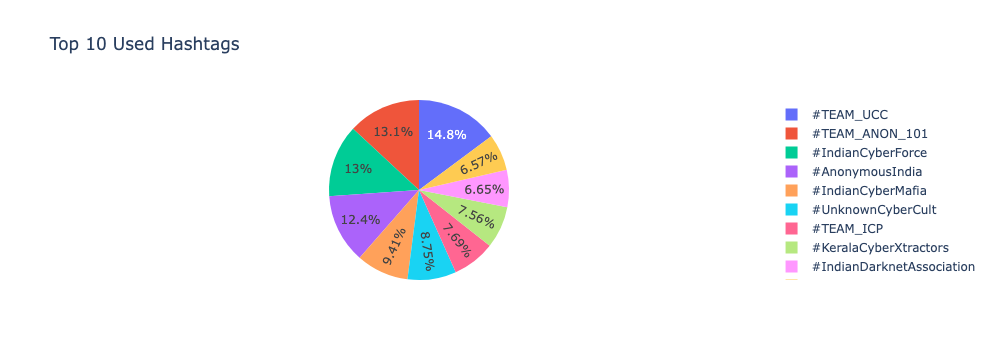

In [19]:
import plotly.express as px

# Assuming hashtag_counts_df is your DataFrame with columns 'hashtag' and 'count'
top_15_hashtags = hashtag_counts_df.head(10)

fig = px.pie(top_15_hashtags, names='hashtags', values='count', title='Top 10 Used Hashtags')

fig.show()

# Display total keyword amount based on criteria

## Count based on "Country"

In [61]:
df_country_count = (
    df
    .groupby(
        ['country'],
        sort=False)
    .size()
    .reset_index(name='count')
    .sort_values(by=['count'],
                 ascending=False)
    .reset_index(drop=True)
)
df_country_count.head(5)

country  count
0    Pakistan   1498
1  Bangladesh    888
2   Indonesia    862
3    Malaysia    278
4     Somalia    254

## Count based on "Country", "Month" & "Search Term"

In [49]:
df_count = (
    df
    .groupby(
        ['country','month','search_term'],
        sort=False)
    .size()
    .reset_index(name='count')
    .sort_values(by=['month'],
                 ascending=True)
    .reset_index(drop=True)
)
df_count

country  month search_term  count
0      Pakistan      2     .gov.pk      8
1      Pakistan      2         .pk     10
2       Somalia      3     .gov.so      2
3      Pakistan      3         .pk    126
4         Libya      3         .ly      1
..          ...    ...         ...    ...
173  Bangladesh     10     .gov.bd     19
174     Somalia     10     .gov.so      4
175    Malaysia     10    Malaysia      1
176       Sudan     10       Sudan     12
177     Lebanon     10     .gov.lb      1

[178 rows x 4 columns]

## Count based on "Country", "Month" & "Group Name"

In [47]:
df_group_count = (
    df
    .groupby(
        ['country','month','group_name'],
        sort=False)
    .size()
    .reset_index(name='count')
    .sort_values(by=['month'],
                 ascending=True)
    .reset_index(drop=True)
)
df_group_count

country  month                    group_name  count
0        Pakistan      2  TeAm UcC OpErAtIoNs • ıllıll     18
1          Brunei      3  TeAm UcC OpErAtIoNs • ıllıll      6
2     North Korea      3          Cyber Club (Support)      1
3           Yemen      3  TeAm UcC OpErAtIoNs • ıllıll     20
4         Somalia      3          Cyber Club (Support)      5
..            ...    ...                           ...    ...
386    Bangladesh     10               𝐀𝐍𝐎𝐍𝐘𝐌𝐎𝐔𝐒 𝐈𝐍𝐃𝐈𝐀      2
387      Malaysia     10            IT ARMY of Ukraine      2
388         Syria     10          Cyber Club (Support)      1
389      Pakistan     10   Sιʅҽɳƚ Oɳҽ (कट्टर हिन्दू 🚩)     55
390  Saudi Arabia     10    ICD - Israel Cyber Defense      1

[391 rows x 4 columns]

## Count based on a specific value

In [65]:
# For one specific value
df_count[df_count['country'] == 'Malaysia']

# For multiple specific values
#filtered_df = df_count[(df_count['country'] == 'Malaysia') & (df_count['month'] == 3)]
#filtered_df

country  month search_term  count
5    Malaysia      3         .my     46
9    Malaysia      3     .gov.my     12
14   Malaysia      3    Malaysia     14
35   Malaysia      4     .gov.my     19
46   Malaysia      4    Malaysia     35
47   Malaysia      4         .my     58
51   Malaysia      5    Malaysia     10
52   Malaysia      5         .my     18
88   Malaysia      6         .my      5
96   Malaysia      7         .my      8
120  Malaysia      8    Malaysia      7
132  Malaysia      8         .my     11
135  Malaysia      9    Malaysia      2
140  Malaysia      9     .gov.my      2
142  Malaysia      9         .my     13
159  Malaysia     10         .my     16
162  Malaysia     10     .gov.my      1
175  Malaysia     10    Malaysia      1

# Bar Chart Visualization

## Bar chart based on keywords of specific country

In [66]:
df_count_viz = (
    df_count[df_count['country'] == 'Malaysia'].hvplot.bar(
        x = 'month',
        y = 'count',
        by = 'search_term',
        title = 'Malaysia Keywords in Year 2023',
        # rot = 90,
        height=500,
        xlabel = 'Month',
        ylabel = 'Count',
        stacked=True
    )
)
df_count_viz

:Bars   [month,search_term]   (count)

## Bar chart based on keywords of specific country

In [52]:
df_group_count[df_group_count['country'] == 'Malaysia']

country  month                    group_name  count
7    Malaysia      3        Kerala Cyber Xtractors      3
17   Malaysia      3    𝐈𝐍𝐃𝐈𝐀𝐍 𝐃𝐀𝐑𝐊𝐍𝐄𝐓 𝐀𝐒𝐒𝐎𝐂𝐈𝐀𝐓𝐈𝐎𝐍      6
21   Malaysia      3            𝐈𝐍𝐃𝐈𝐀𝐍 𝐂𝐘𝐁𝐄𝐑 𝐅𝐎𝐑𝐂𝐄     13
25   Malaysia      3          Cyber Club (Support)      3
31   Malaysia      3  TeAm UcC OpErAtIoNs • ıllıll     47
46   Malaysia      4    𝐈𝐍𝐃𝐈𝐀𝐍 𝐃𝐀𝐑𝐊𝐍𝐄𝐓 𝐀𝐒𝐒𝐎𝐂𝐈𝐀𝐓𝐈𝐎𝐍      5
52   Malaysia      4               𝐀𝐍𝐎𝐍𝐘𝐌𝐎𝐔𝐒 𝐈𝐍𝐃𝐈𝐀      8
54   Malaysia      4            𝐈𝐍𝐃𝐈𝐀𝐍 𝐂𝐘𝐁𝐄𝐑 𝐅𝐎𝐑𝐂𝐄     10
64   Malaysia      4              Termux Israel 🇮🇱      1
65   Malaysia      4  TeAm UcC OpErAtIoNs • ıllıll     33
69   Malaysia      4          Cyber Club (Support)      5
81   Malaysia      4             𝐓𝐄𝐀𝐌 𝐍𝐖𝐇 𝐒𝐄𝐂𝐔𝐑𝐈𝐓𝐘     18
84   Malaysia      4        Kerala Cyber Xtractors     32
96   Malaysia      5  TeAm UcC OpErAtIoNs • ıllıll     10
103  Malaysia      5            𝐈𝐍𝐃𝐈𝐀𝐍 𝐂𝐘𝐁𝐄𝐑 𝐅𝐎𝐑𝐂𝐄      4
109  Malaysia      5        Kerala Cyber Xtractors     11
117  Malaysia      5          Cyber Club (Support)      2
134  Malaysia      5    𝐈𝐍𝐃𝐈𝐀𝐍 𝐃𝐀𝐑𝐊𝐍𝐄𝐓 𝐀𝐒𝐒𝐎𝐂𝐈𝐀𝐓𝐈𝐎𝐍      1
148  Malaysia      6            𝐈𝐍𝐃𝐈𝐀𝐍 𝐂𝐘𝐁𝐄𝐑 𝐅𝐎𝐑𝐂𝐄      1
163  Malaysia      6          Cyber Club (Support)      4
185  Malaysia      7            IT ARMY of Ukraine      1
189  Malaysia      7            𝐈𝐍𝐃𝐈𝐀𝐍 𝐂𝐘𝐁𝐄𝐑 𝐅𝐎𝐑𝐂𝐄      1
195  Malaysia      7          Cyber Club (Support)      1
196  Malaysia      7              Termux Israel 🇮🇱      1
198  Malaysia      7             𝐓𝐄𝐀𝐌 𝐍𝐖𝐇 𝐒𝐄𝐂𝐔𝐑𝐈𝐓𝐘      2
205  Malaysia      7  TeAm UcC OpErAtIoNs • ıllıll      1
213  Malaysia      7            DARK CYBER WARRIOR      1
217  Malaysia      8            DARK CYBER WARRIOR      2
225  Malaysia      8                     ThreatSec      1
227  Malaysia      8        Kerala Cyber Xtractors      1
232  Malaysia      8               𝐀𝐍𝐎𝐍𝐘𝐌𝐎𝐔𝐒 𝐈𝐍𝐃𝐈𝐀      1
242  Malaysia      8  TeAm UcC OpErAtIoNs • ıllıll      4
249  Malaysia      8          Cyber Club (Support)      2
251  Malaysia      8             𝐓𝐄𝐀𝐌 𝐍𝐖𝐇 𝐒𝐄𝐂𝐔𝐑𝐈𝐓𝐘      2
265  Malaysia      8    ICD - Israel Cyber Defense      2
269  Malaysia      8            𝐈𝐍𝐃𝐈𝐀𝐍 𝐂𝐘𝐁𝐄𝐑 𝐅𝐎𝐑𝐂𝐄      1
273  Malaysia      8   Sιʅҽɳƚ Oɳҽ (कट्टर हिन्दू 🚩)      1
282  Malaysia      9         𝐊𝐄𝐑𝐀𝐋𝐀 𝐂𝐘𝐁𝐄𝐑 𝐓𝐇𝐔𝐍𝐃𝐄𝐑𝐒      1
285  Malaysia      9             𝐓𝐄𝐀𝐌 𝐍𝐖𝐇 𝐒𝐄𝐂𝐔𝐑𝐈𝐓𝐘      2
287  Malaysia      9          Cyber Club (Support)      5
294  Malaysia      9    ICD - Israel Cyber Defense      1
301  Malaysia      9            IT ARMY of Ukraine      1
303  Malaysia      9              Termux Israel 🇮🇱      2
312  Malaysia      9            𝐈𝐍𝐃𝐈𝐀𝐍 𝐂𝐘𝐁𝐄𝐑 𝐅𝐎𝐑𝐂𝐄      1
315  Malaysia      9   Sιʅҽɳƚ Oɳҽ (कट्टर हिन्दू 🚩)      1
322  Malaysia      9            DARK CYBER WARRIOR      1
325  Malaysia      9                     ThreatSec      1
326  Malaysia      9  TeAm UcC OpErAtIoNs • ıllıll      1
349  Malaysia     10  TeAm UcC OpErAtIoNs • ıllıll      1
352  Malaysia     10          Cyber Club (Support)     11
374  Malaysia     10   Sιʅҽɳƚ Oɳҽ (कट्टर हिन्दू 🚩)      4
387  Malaysia     10            IT ARMY of Ukraine      2

In [69]:
df_group_viz = (
    df_group_count[(df_group_count['country'] == 'Malaysia') & (df_count['month'] == 3)].hvplot.bar(
        x = 'month',
        y = 'count',
        by='group_name',
        # by = 'recipient',
        title = 'Pro-Israeli Telegram groups that mentioned Malaysia in Year 2023',
        # rot = 90,
        height=500,
        xlabel = 'Month',
        ylabel = 'Count',
        stacked=False
    )
)
df_group_viz

:Bars   [month,group_name]   (count)

# Horizontal Bar Chart

In [82]:
df_country_viz = (
    df_country_count.hvplot.barh(
        x = 'country',
        y = 'count',
        #by = 'country',
        title = 'Countries that were attacked by Pro-Israeli hacker groups in 2023',
        # rot = 90,
        height=500,
        width=1200,
        xlabel = 'Country',
        ylabel = 'Count',
        stacked=True,
    )
)
df_country_viz

:Bars   [country]   (count)

# Sankey Diagram Visualization

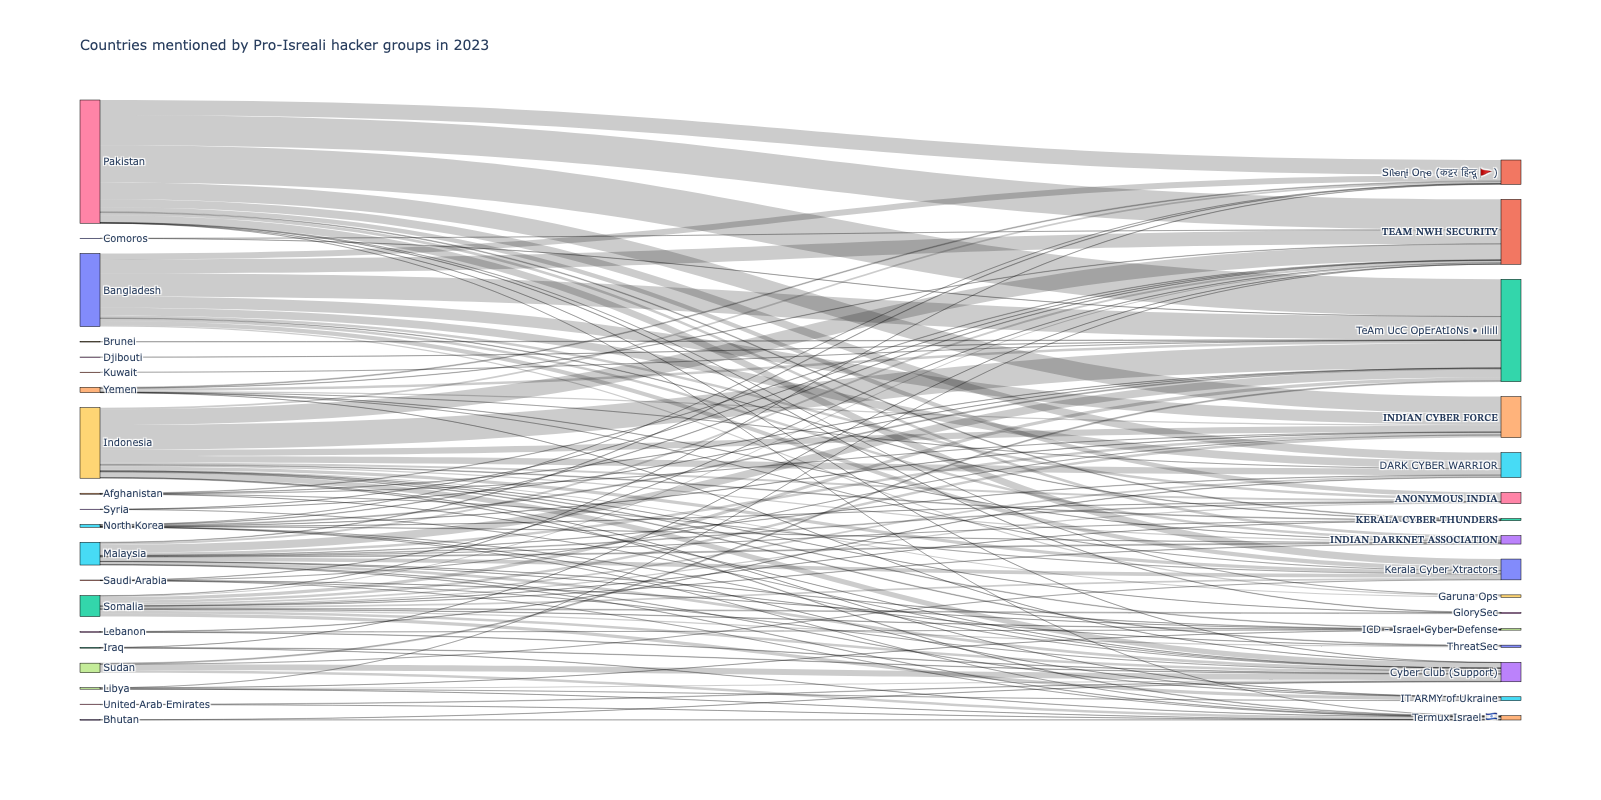

In [96]:
sankey = (
    genSankey(
        df_group_count,
        cat_cols=['country', 'group_name'],
        value_cols='count',
        title='Countries mentioned by Pro-Isreali hacker groups in 2023'
    )
)

df_count_viz = go.Figure(sankey)
df_count_viz.update_layout(width=1500,height=800)
df_count_viz.show()

# Multiple Flow Sankey Diagram

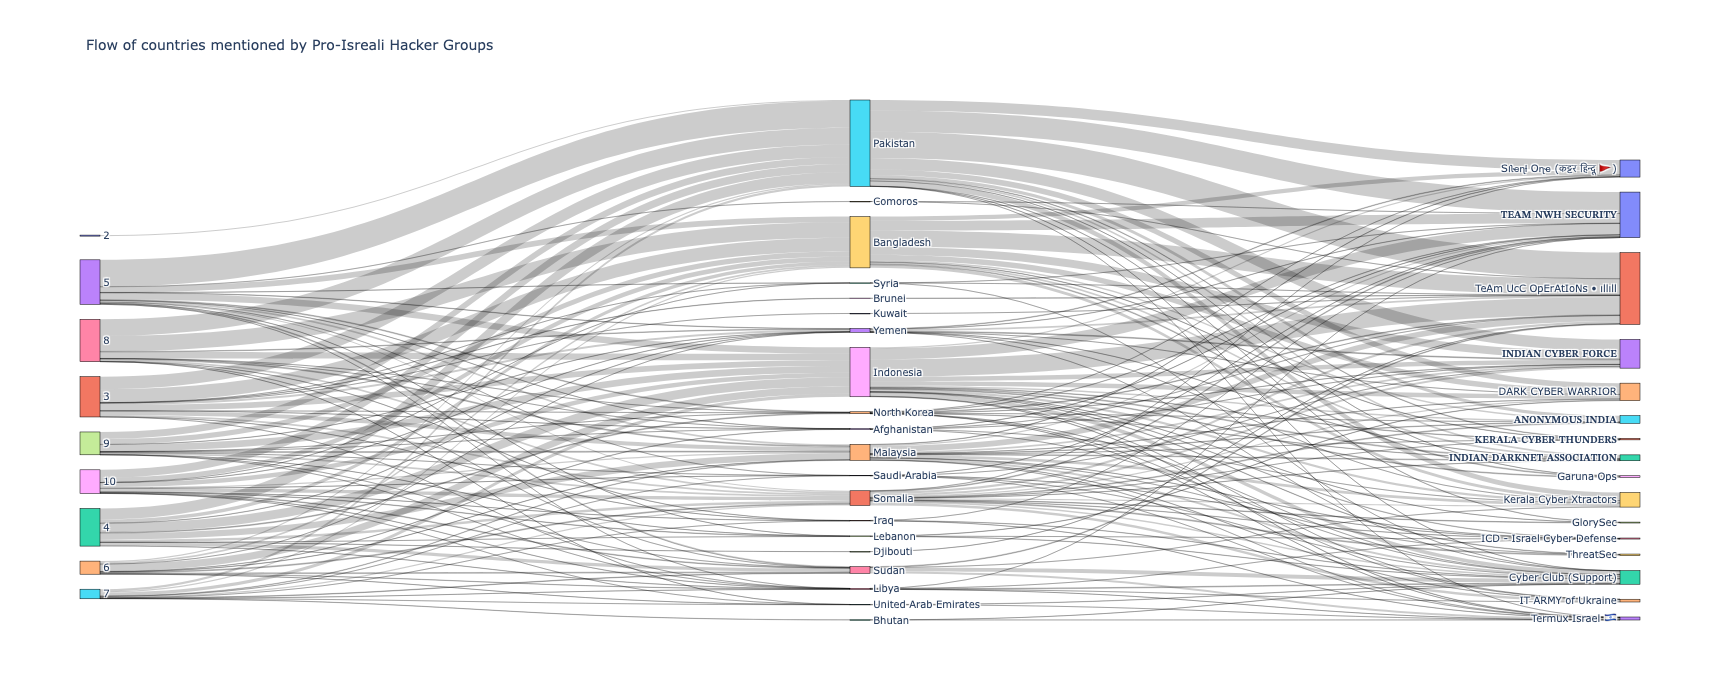

In [98]:
sankey = (
    genSankey(
        df_group_count,
        cat_cols=['month', 'country','group_name'],
        value_cols='count',
        title='Flow of countries mentioned by Pro-Isreali Hacker Groups'
    )
)

df_count_viz = go.Figure(sankey)
df_count_viz.update_layout(width=1300,height=700)
df_count_viz.show()